In [269]:
import pandas as pd
import numpy as np
from scipy.stats import mode

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

# import wget
import pickle

In [239]:
sns.set()

In [240]:
train_data = pd.read_csv('/kaggle/input/predictingbookratingsint20h/train.csv')

In [241]:
test_data = pd.read_csv('/kaggle/input/predictingbookratingsint20h/test.csv')

In [242]:
train_data.head()

,id,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_review_count,book_rating_count,book_rating
0,0,Forastera,https://images.gr-assets.com/books/1500683049l...,"Recién acabada la Segunda Guerra Mundial, una ...",Historical|Historical Fiction|Romance|Fantasy|...,Diana Gabaldon|Carmen Bordeu,Kindle Edition,768 pages,40197,668892,4.22
1,1,Writing about Magic,https://images.gr-assets.com/books/1445900480l...,Do you write fantasy fiction? This book is a r...,Language|Writing|Nonfiction,Rayne Hall,Paperback,180 pages,27,126,3.95
2,2,The Stress of Her Regard,https://images.gr-assets.com/books/1503059955l...,When Michael Crawford discovers his bride brut...,Fantasy|Horror|Paranormal|Vampires|Historical|...,Tim Powers,Paperback,470 pages,331,3626,3.79
3,3,The Horrors and Absurdities of Religion,https://images.gr-assets.com/books/1409779869l...,"A fascinating examination of ethics, religion ...",Philosophy|Religion|Nonfiction|Classics,Arthur Schopenhauer,Paperback,106 pages,28,371,3.85
4,4,Three Tales,https://images.gr-assets.com/books/1311645483l...,"First published in 1877, these three stories a...",Fiction|Short Stories|Classics|Cultural|France...,Gustave Flaubert|Roger Whitehouse|Geoffrey Wall,Paperback,110 pages,250,4331,3.72


In [243]:
train_data.iloc[1,2]

'https://images.gr-assets.com/books/1445900480l/27282801.jpg'

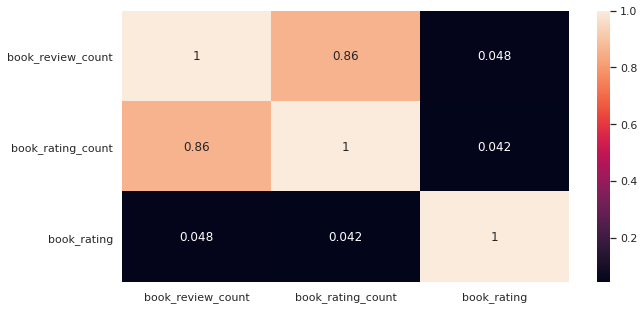

In [244]:
plt.figure(figsize=(10, 5))
sns.heatmap(train_data.drop(columns='id').corr(), annot=True)

plt.yticks(rotation=0);

In [245]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 40000 non-null  int64  
 1   book_title         40000 non-null  object 
 2   book_image_url     39608 non-null  object 
 3   book_desc          40000 non-null  object 
 4   book_genre         37551 non-null  object 
 5   book_authors       40000 non-null  object 
 6   book_format        39080 non-null  object 
 7   book_pages         38141 non-null  object 
 8   book_review_count  40000 non-null  int64  
 9   book_rating_count  40000 non-null  int64  
 10  book_rating        40000 non-null  float64
dtypes: float64(1), int64(3), object(7)
memory usage: 3.4+ MB


In [246]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 3020 non-null   int64 
 1   book_title         3020 non-null   object
 2   book_image_url     3020 non-null   object
 3   book_desc          3020 non-null   object
 4   book_genre         3020 non-null   object
 5   book_authors       3020 non-null   object
 6   book_format        3020 non-null   object
 7   book_pages         3020 non-null   object
 8   book_review_count  3020 non-null   int64 
 9   book_rating_count  3020 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 236.1+ KB


## book_count

In [247]:
def get_dict_authors():
    d = {}
    for line in train_data['book_authors'].values:
        for author in np.unique(line.split('|')):
            d.setdefault(author, 0)
            d[author] += 1
    
    return d

dict_authors = get_dict_authors()

In [248]:
def get_book_count(s):
    arr = []
    for author in np.unique(s.split('|')):
        arr.append(dict_authors.get(author, 0))
    
    return max(arr)
        
train_data['book_count'] = train_data['book_authors'].map(get_book_count)

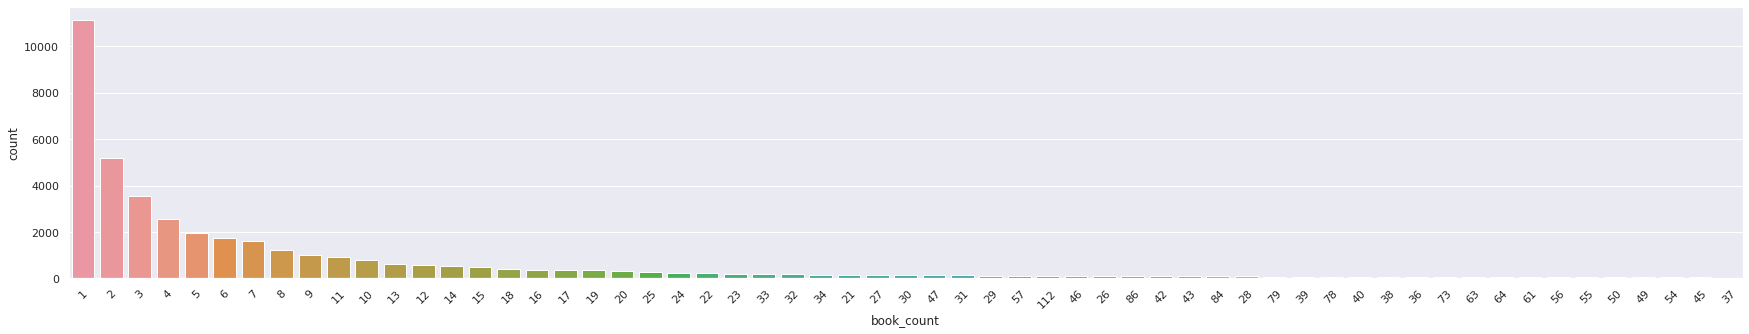

In [249]:
plt.figure(figsize=(30, 5))
sns.countplot(x='book_count', data=train_data, order=train_data['book_count'].value_counts().index)
plt.xticks(rotation=45);

In [251]:
test_data['book_count'] = test_data['book_authors'].map(get_book_count)

## book_format

In [252]:
# def get_book_format(s):
#     if s in ['Paperback', 'Hardcover', 'Mass Market Paperback']:
#         return 1
#     elif s in ['Kindle Edition', 'ebook', 'Nook']:
#         return 2
#     elif s in ['Audio CD', 'Audiobook', 'Audible Audio', 'Audio']:
#         return 3
#     else:
#         return 4
    

In [253]:
# train_data['book_format'].value_counts().head(50)

In [254]:
# train_data['book_format'] = train_data['book_format'].map(get_book_format)

In [255]:
# sns.histplot(x='book_rating_count',data=train_data)

## book_pages

In [256]:
train_data['book_pages'] = pd.to_numeric(train_data['book_pages'].str.extract(r'(\d+)', expand=False), errors='coerce')
train_data['book_pages'] = train_data['book_pages'].fillna(320)

In [257]:
test_data['book_pages'] = pd.to_numeric(test_data['book_pages'].str.extract(r'(\d+)', expand=False), errors='coerce')
test_data['book_pages'] = test_data['book_pages'].fillna(320)

## train_test_split

In [273]:
X = train_data.drop(columns='book_rating')
y = train_data['book_rating']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [274]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=0.2)
X_train_vectorized = vectorizer.fit_transform(X_train['book_desc'])
X_valid_vectorized = vectorizer.transform(X_valid['book_desc'])

X_test_vectorized = vectorizer.transform(test_data['book_desc'])

In [275]:
X_train = np.concatenate([X_train_vectorized.toarray(), X_train[['book_pages', 'book_rating_count']]], axis=1)
X_valid = np.concatenate([X_valid_vectorized.toarray(), X_valid[['book_pages', 'book_rating_count']]], axis=1)

X_test = np.concatenate([X_test_vectorized.toarray(), test_data[['book_pages', 'book_rating_count']]], axis=1)

## model

In [276]:
clf_xgb = XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=500, n_jobs=-1)
clf_xgb.fit(X_train, y_train)
y_pred = clf_xgb.predict(X_valid)

In [277]:
mean_squared_error(y_valid, y_pred, squared=False)

0.3106687812620348

In [270]:
pickle.dump(clf_xgb, open('model.pickle', 'wb'))

In [ ]:
# param_xgb = {'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [2, 4, 8],
#              'n_estimators': [100, 200, 500]}

In [ ]:
# grid_xgb = GridSearchCV(clf_xgb, param_xgb, scoring='neg_root_mean_squared_error', cv=5)
# grid_xgb.fit(X_train, y_train)
# grid_xgb.best_params_

## submission

In [271]:
submission = pd.DataFrame({'id': test_data['id'], 'book_rating': clf_xgb.predict(X_test)})
submission

,id,book_rating
0,0,3.811390
1,1,3.933418
2,2,3.893346
3,3,3.886621
4,4,4.140232
...,...,...
3015,3015,3.774328
3016,3016,3.821634
3017,3017,4.027277
3018,3018,3.904339


In [272]:
submission.to_csv('submission.csv', index=False)